# Week 7 Assignment
Wiley Winters</br>
MSDS 670 Data Visualization</br>
2024-MAR-03</br>

-------------------------------------------------------------------------------
Import required packages and libraries

In [1]:
# Import Libraries
import pandas as pd

#Import plotly libraries
import plotly.express as px
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Load dataset into Pandas DataFrame and perform some basic EDA

In [2]:
covid_df = pd.read_csv('../data/Provisional_COVID-19_Deaths_by_Sex_and_Age_20240227.csv')
abbrv_df = pd.read_csv('../data/stateAbb.csv')
popul_df = pd.read_csv('../data/statesPop2023.csv')

In [3]:
covid_df.columns

Index(['Data As Of', 'Start Date', 'End Date', 'Group', 'Year', 'Month',
       'State', 'Sex', 'Age Group', 'COVID-19 Deaths', 'Total Deaths',
       'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 'Influenza Deaths',
       'Pneumonia, Influenza, or COVID-19 Deaths', 'Footnote'],
      dtype='object')

I will change column names to be ones that are easier to work with.

In [4]:
cols = ['date', 'start', 'end', 'group', 'year', 'month', 'state', 'sex', 'age_group', 
        'covid_deaths', 'total_deaths', 'pneunonia_deaths', 'pneunonia_covid_deaths',
        'influenza_deaths', 'pneumonia_influenza_covid_deaths', 'footnote']
covid_df.columns = cols
covid_df.columns

Index(['date', 'start', 'end', 'group', 'year', 'month', 'state', 'sex',
       'age_group', 'covid_deaths', 'total_deaths', 'pneunonia_deaths',
       'pneunonia_covid_deaths', 'influenza_deaths',
       'pneumonia_influenza_covid_deaths', 'footnote'],
      dtype='object')

Merge all of the dataframes into one.  covid_df will be the dataframe merged into

In [5]:
all_df = covid_df.merge(abbrv_df, on='state', how='left').merge(popul_df, on='state', 
                                                                how='left')
all_df.columns

Index(['date', 'start', 'end', 'group', 'year', 'month', 'state', 'sex',
       'age_group', 'covid_deaths', 'total_deaths', 'pneunonia_deaths',
       'pneunonia_covid_deaths', 'influenza_deaths',
       'pneumonia_influenza_covid_deaths', 'footnote', 'abbreviation',
       'population'],
      dtype='object')

The formula for it is $crude death rate = (number of deaths / total population) * 100,000$.  This will give the *crude death rate* per *100,000* people.  For this project I will use a *crude death rate* per *10,000* people instead of 100,000.  Some of the western states have very small populations

In [6]:
all_df['crude_deaths'] = round((all_df['covid_deaths'] / all_df['population']) * 1000)

There are a lot of missing values.  For this study I want to concentrate on COVID-19 deaths.  I will drop the other columns

In [7]:
drop_cols = ['pneunonia_deaths', 'pneunonia_covid_deaths', 'influenza_deaths',
             'pneumonia_influenza_covid_deaths', 'footnote']
all_df.drop(drop_cols, axis=1, inplace=True)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137700 entries, 0 to 137699
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          137700 non-null  object 
 1   start         137700 non-null  object 
 2   end           137700 non-null  object 
 3   group         137700 non-null  object 
 4   year          134946 non-null  float64
 5   month         123930 non-null  float64
 6   state         137700 non-null  object 
 7   sex           137700 non-null  object 
 8   age_group     137700 non-null  object 
 9   covid_deaths  98270 non-null   float64
 10  total_deaths  118191 non-null  float64
 11  abbreviation  130050 non-null  object 
 12  population    130050 non-null  float64
 13  crude_deaths  92261 non-null   float64
dtypes: float64(6), object(8)
memory usage: 14.7+ MB


In addition, there are some columns marked as objects that are actually dates.  I will be using dates in this analysis, so have to convert data type to date.

In [8]:
date_cols = ['date', 'start', 'end']
all_df[date_cols] = all_df[date_cols].astype('datetime64[ns]')

In [9]:
print(all_df.info())
print('\nNaN Values:\n', all_df.isna().sum())
print('\nDuplicates: ', all_df.duplicated().sum())
print('\nSize: ', all_df.size)
print('\nDistribution:\n', all_df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137700 entries, 0 to 137699
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          137700 non-null  datetime64[ns]
 1   start         137700 non-null  datetime64[ns]
 2   end           137700 non-null  datetime64[ns]
 3   group         137700 non-null  object        
 4   year          134946 non-null  float64       
 5   month         123930 non-null  float64       
 6   state         137700 non-null  object        
 7   sex           137700 non-null  object        
 8   age_group     137700 non-null  object        
 9   covid_deaths  98270 non-null   float64       
 10  total_deaths  118191 non-null  float64       
 11  abbreviation  130050 non-null  object        
 12  population    130050 non-null  float64       
 13  crude_deaths  92261 non-null   float64       
dtypes: datetime64[ns](3), float64(6), object(5)
memory usage: 14.7+ MB
N

There are many missing values; however, according to the dataset's website, the information may have not been recorded yet.  Therefore, I will leave them as `NaN` for now.

---------------------------------------------------------------------
Perform EDA to determine what type of information can be obtained from this dataset

In [10]:
all_df.groupby('year').agg({'crude_deaths': 'mean'}). \
         sort_values('crude_deaths', ascending=False)

,crude_deaths
year,
2021.0,0.006120
2020.0,0.005143
2022.0,0.002639
2023.0,0.000000


In [11]:
data_df = all_df[(all_df.group == 'By Total') & (all_df.state != 'United States') & \
                 (all_df.end > '12/31/2022') & (all_df.sex == 'All Sexes') & \
                 (all_df.age_group == 'All Ages')]
data_df.head()

,date,start,end,group,year,month,state,sex,age_group,covid_deaths,total_deaths,abbreviation,population,crude_deaths
51,2023-09-27,2020-01-01,2023-09-23,By Total,NaN,NaN,Alabama,All Sexes,All Ages,21520.0,231602.0,AL,5108468.0,4.0
102,2023-09-27,2020-01-01,2023-09-23,By Total,NaN,NaN,Alaska,All Sexes,All Ages,1492.0,20039.0,AK,733406.0,2.0
153,2023-09-27,2020-01-01,2023-09-23,By Total,NaN,NaN,Arizona,All Sexes,All Ages,30307.0,284393.0,AZ,7431344.0,4.0
204,2023-09-27,2020-01-01,2023-09-23,By Total,NaN,NaN,Arkansas,All Sexes,All Ages,12663.0,140174.0,AR,3067732.0,4.0
255,2023-09-27,2020-01-01,2023-09-23,By Total,NaN,NaN,California,All Sexes,All Ages,109248.0,1178346.0,CA,38965193.0,3.0


The data I want to use has been filtered out of the original DataFrame.  For the choropleth only a few columns are required.  I will drop the rest.

In [12]:
drop_cols = ['date', 'start', 'end', 'group', 'year', 'month', 'state', 'sex',
             'age_group', 'total_deaths']
data_df.drop(drop_cols, axis=1, inplace=True)

In [13]:
data_df.head()

,covid_deaths,abbreviation,population,crude_deaths
51,21520.0,AL,5108468.0,4.0
102,1492.0,AK,733406.0,2.0
153,30307.0,AZ,7431344.0,4.0
204,12663.0,AR,3067732.0,4.0
255,109248.0,CA,38965193.0,3.0


In [14]:
data_df['text'] = 'State: '+data_df.abbreviation + '<br>' + \
                  'Crude Deaths: '+data_df.crude_deaths.astype(str)
text = data_df['text'].tolist()

In [15]:
data = [dict(type='choropleth', autocolorscale=False, locations=data_df.abbreviation,
             z=data_df.crude_deaths, locationmode='USA-states', text=['text'],
             colorscale='Viridis', colorbar=dict(title='Crude Death Rate'))]

In [16]:
layout = dict(title='COVID-19 Crude Death Rate per 1,000 by State',
              geo=dict(scope='usa', projection=dict(type='albers usa'),
                       showlakes=True, lakecolor='rgb(66,165,245)'))

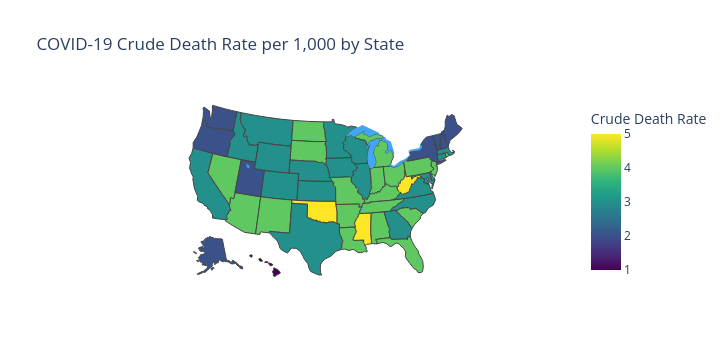

In [17]:
# Save choropleth to a HTML file
plotly.offline.plot({'data': data, 'layout': layout},
                    filename='../images/mapUSA01.html')
# Display choropleth in jupyter-lab
plotly.offline.iplot({'data': data, 'layout': layout})

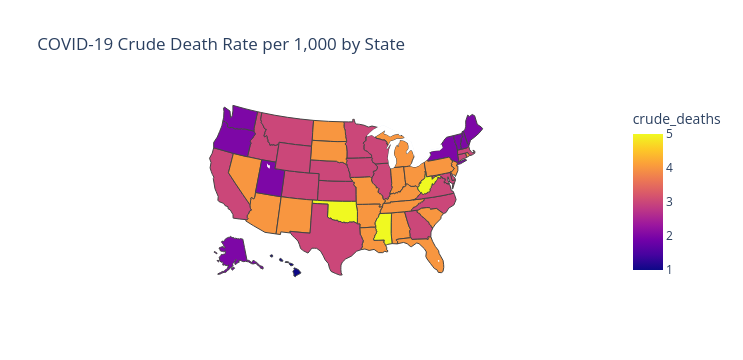

In [18]:
fig = px.choropleth(data_df, locations='abbreviation', locationmode='USA-states',
                    color='crude_deaths', scope='usa', 
                    title='COVID-19 Crude Death Rate per 1,000 by State',
                    hover_data='crude_deaths')
fig.update_layout(hoverlabel=dict(bgcolor='wheat', font_size=15))
fig.show()
fig.write_html('../images/mapUSA.html')

In [19]:
data_df.groupby('abbreviation').agg({'crude_deaths':'max'}). \
        sort_values('crude_deaths', ascending=False).head(10)

,crude_deaths
abbreviation,
MS,5.0
OK,5.0
WV,5.0
AL,4.0
MO,4.0
MI,4.0
NJ,4.0
NM,4.0
NV,4.0


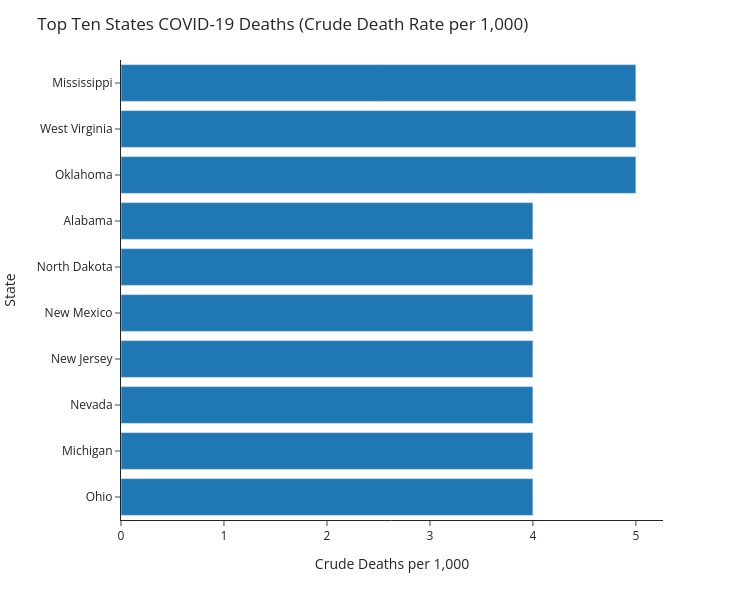

In [20]:
plot = all_df.groupby('state').agg({'crude_deaths':'max'}). \
              sort_values('crude_deaths', ascending=False).reset_index().head(10)
fig = px.bar(plot, x='crude_deaths', y='state', template='simple_white',
             width=800, height=600, labels={'crude_deaths': 'Crude Deaths per 1,000',
                                            'state': 'State'})
fig.update_layout(title='Top Ten States COVID-19 Deaths (Crude Death Rate per 1,000)',
                  hoverlabel=dict(bgcolor='wheat', font_size=15), hovermode='x')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()
fig.write_html('../images/top10CRD.html')

In [21]:
all_usa = all_df[all_df.state != 'United States']
all_usa.groupby('state').agg({'crude_deaths':'max'}). \
       sort_values('crude_deaths', ascending=False).head(10)

,crude_deaths
state,
Oklahoma,5.0
West Virginia,5.0
Mississippi,5.0
Ohio,4.0
Michigan,4.0
Nevada,4.0
New Jersey,4.0
New Mexico,4.0
North Dakota,4.0


In [22]:
all_df.groupby('state').agg({'covid_deaths':'max'}). \
       sort_values('covid_deaths', ascending=False).head(10)

,covid_deaths
state,
United States,1146774.0
California,109248.0
Texas,104421.0
Florida,81894.0
Pennsylvania,53049.0
Ohio,49729.0
New York,42273.0
Illinois,38724.0
New York City,38167.0


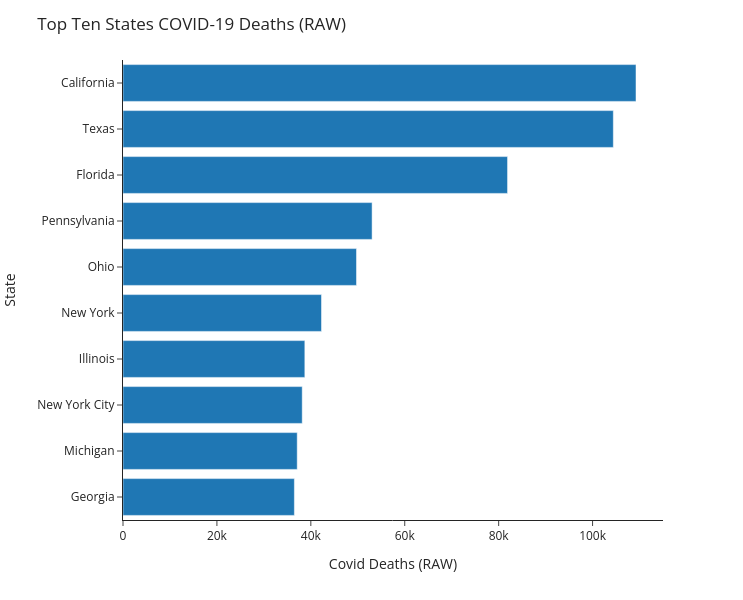

In [23]:
plot = all_usa.groupby('state').agg({'covid_deaths':'max'}). \
               sort_values('covid_deaths', ascending=False).reset_index().head(10)
fig = px.bar(plot, x='covid_deaths', y='state', template='simple_white',
             width=800, height=600, labels=({'covid_deaths': 'Covid Deaths (RAW)',
                                             'state': 'State'}))
fig.update_layout(title='Top Ten States COVID-19 Deaths (RAW)',
                  hoverlabel=dict(bgcolor='wheat', font_size=15), hovermode='x')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()
fig.write_html('../images/top10RAW.html')